In [1]:
import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Empirical
from pyprob import diagnostics

import torch
import numpy as np
import math
import os
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure();

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<Figure size 432x288 with 0 Axes>

In [2]:
train_num_traces = 50000

exp_name = 'notebook-gum'
out_dir = 'mmd_plots'
store_plots = False

if store_plots and (not os.path.exists(out_dir)):
    os.makedirs(out_dir)


class MMDLogger:
    def __init__(self, store_plots):
        self.store_plots = store_plots
        self.mmd_info = {} # a dictionary from variable address to the triple [mmd, p_val, num_traces]
        
    def update(self, variable_values, num_traces):
        for v in variable_values.values():
            name = v['variable'].name
            address = v['variable'].address
            mmd = v['mmd']
            p_val = v['p_val']
            
            if address not in self.mmd_info:
                self.mmd_info[address] = []
            self.mmd_info[address].append([mmd, p_val, num_traces])
            
            
            fig = plt.figure(figsize=(10, 5), dpi=200)
            plt.hist(v['values_p'], bins=50, alpha=0.5, density=True, label='P')
            plt.hist(v['values_q'], bins=50, alpha=0.5, density=True, label='Q', color='green')
            plt.legend()
            plt.title('var: {}, traces = {}, p-value = {}, mmd = {}'.format(v['variable'].name, (iter_num+1)*train_num_traces, v['p_val'], v['mmd']))
            plt.xlim(left=2, right=12)
            plt.ylim(bottom=0,top=1)
            if store_plots:
                fig.savefig('{}/{}_{}_{}.png'.format(out_dir, exp_name, v['variable'].name, iter_num))
                plt.close('all')
                
    def plotSummary(self, force=False):
        # If not forced, only plots if should store them in the file.
        if (not store_plots) and (not force):
            return
        for address in self.mmd_info:
            fig, axarr = plt.subplots(2, sharex=True, figsize=(10, 10), dpi=200) # Create an empty plot containing 2 subplots, sharing x axis (for MMD and p-value)
            mmd_vals = [mmd for [mmd, p_val, x] in self.mmd_info[address]]
            p_vals = [p_val for [mmd, p_val, x] in self.mmd_info[address]]
            x_vals = [x for [mmd, p_val, x] in self.mmd_info[address]]
            axarr[0].plot(x_vals, mmd_vals, label='MMD')
            axarr[0].set_title('MMD statistics')
            axarr[1].scatter(x_vals, p_vals, marker='x', label='p-value')
            axarr[1].axhline(y=0.05, color='tab:gray', linestyle='--')
            axarr[1].set_title('MMD test p-values')
            fig.suptitle('Variable address: {}'.format(address))
            fig.text(0.5, 0.09, 'Training iteration', ha='center', va='center')
            if store_plots:
                fig.savefig('{}/{}_{}_plot.png'.format(out_dir, exp_name, v['variable'].name))
                plt.close('all')
                
    def close(self):
        self.plotSummary(force=True)

# Defining the model
First, we define the model as a probabilistic program inheriting from `pyprob.Model`. Models inherit from `torch.nn.Module` and can be potentially trained with gradient-based optimization (not covered in this example).

The `forward` function can have any number and type of arguments as needed.

In [3]:
class GaussianUnknownMean(Model):
    def __init__(self):
        super().__init__(name='Gaussian with unknown mean') # give the model a name
        self.prior_mean = 1
        self.prior_std = math.sqrt(5)
        self.likelihood_std = math.sqrt(2)

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) mean variable to be inferred:
        mu = pyprob.sample(Normal(self.prior_mean, self.prior_std), address = 'mu') # NOTE: sample -> denotes latent variables

        # define the likelihood
        likelihood = Normal(mu, self.likelihood_std)

        # Lets add two observed variables
        # -> the 'name' argument is used later to assignment values:
        pyprob.observe(likelihood, name='obs0') # NOTE: observe -> denotes observable variables
        pyprob.observe(likelihood, name='obs1')

        # return the latent quantity of interest
        return mu
    
model = GaussianUnknownMean()

# Finding the correct posterior analytically
Since all distributions are gaussians in this model, we can analytically compute the posterior and we can compare the true posterior to the inferenced one.

Assuming that the prior and likelihood are $p(x) = \mathcal{N}(\mu_0, \sigma_0)$ and $p(y|x) = \mathcal{N}(x, \sigma)$ respectively and, $y_1, y_2, \ldots y_n$ are the observed values, the posterior would be $p(x|y) = \mathcal{N}(\mu_p, \sigma_p)$ where,
$$
\begin{align}
\sigma_{p}^{2} & = \frac{1}{\frac{n}{\sigma^2} + \frac{1}{\sigma_{0}^{2}}} \\
\mu_p & = \sigma_{p}^{2} \left( \frac{\mu_0}{\sigma_{0}^{2}} + \frac{n\overline{y}}{\sigma^2} \right)
\end{align}
$$
The following class implements computing this posterior distribution. We also implement some helper functions and variables for plotting the correct posterior and prior.

In [4]:
def plot_function(min_val, max_val, func, *args, **kwargs):
        x = np.linspace(min_val,max_val,int((max_val-min_val)*50))
        plt.plot(x, np.vectorize(func)(x), *args, **kwargs)

def get_dist_pdf(dist):
    return lambda x: math.exp(dist.log_prob(x))
        
class CorrectDistributions:
    def __init__(self, model):
        self.prior_mean = model.prior_mean
        self.prior_std = model.prior_std
        self.likelihood_std = model.likelihood_std
        self.prior_dist = Normal(self.prior_mean, self.prior_std)
        
    @property
    def observed_list(self):
        return self.__observed_list

    @observed_list.setter
    def observed_list(self, new_observed_list):
        self.__observed_list = new_observed_list
        self.construct_correct_posterior()
    
    def construct_correct_posterior(self):
        n = len(self.observed_list)
        posterior_var = 1/(n/self.likelihood_std**2 + 1/self.prior_std**2)
        posterior_mu = posterior_var * (self.prior_mean/self.prior_std**2 + n*np.mean(self.observed_list)/self.likelihood_std**2)
        self.posterior_std = math.sqrt(posterior_var)
        self.posterior_mean = posterior_mu
        self.posterior_dist = Normal(posterior_mu, math.sqrt(posterior_var))

    def prior_pdf(self, model, x):
        p = Normal(model.prior_mean,model.prior_stdd)
        return math.exp(p.log_prob(x))

    def plot_posterior(self, min_val, max_val):
        if not hasattr(self, 'posterior_dist'):
            raise AttributeError('observed values are not set yet, and posterior is not defined.')
        plot_function(min_val, max_val, get_dist_pdf(self.posterior_dist), label='correct posterior', color='orange')


    def plot_prior(self, min_val, max_val):
        plot_function(min_val, max_val, get_dist_pdf(self.prior_dist), label='prior', color='green')

correct_dists = CorrectDistributions(model)
correct_dists.observed_list = [8,9]

# Defining the correct model
We define a new model which samples latent variables from the posterior distribution of the previous model.

In [5]:
class CorrectModel(Model):
    def __init__(self, mean, std):
        super().__init__(name='Gaussian with unknown mean') # give the model a name
        self.dist = Normal(mean, std)

    def forward(self):
        mu = pyprob.sample(self.dist, address = 'mu')
        return mu
    
correct_model = CorrectModel(correct_dists.posterior_mean, correct_dists.posterior_std)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 5000/5000 | 6,631.20       


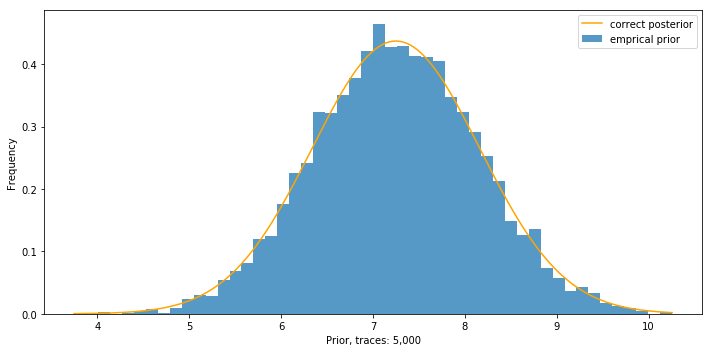

In [6]:
prior = correct_model.prior_distribution(num_traces=5000)
prior.plot_histogram(show=False, alpha=0.75, label='emprical prior', bins=50)
correct_dists.plot_posterior(min(prior.values_numpy()),max(prior.values_numpy()))
plt.legend();

# Maximum Mean Discrepancy
Maximum Mean Discrepency is a distance defined on the space of probability distributions. It is based on the notion of embedding probabilities in areproducing kernel Hilbert space and is defined as follows:

$$
\begin{equation}
\text{MMD}_{k}^2(P, Q)
:= \mathbb{E}_{x,x'}[k(x, x')]
    + \mathbb{E}_{y,y'}[k(y, y')]
    - 2 \mathbb{E}_{x,y}[k(x, y)]
\label{eq:mmd}
\tag{1}
\end{equation}
$$

Where $x,x' \overset{iid}{\sim} P$ and $y,y' \overset{iid}{\sim} Q$ and $k$ is the kernel of a reproducing kernel Hilbert space (RKHS) $\mathcal{H}_k$,

On the practical side, since there is expectations in \ref{eq:mmd}, we use the following unbiased estimate of it:

Given $X = \{X_1, \ldots, X_m\} \overset{iid}{\sim} P$ and $Y = \{Y_1, \ldots, Y_m\} \overset{iid}{\sim} Q$,

$$
\begin{equation}
\widehat{\text{MMD}}_{k}^2(P, Q)
:= \frac{1}{{m \choose 2}}\sum_{i \neq i'}k(X_i, X_{i'})
    + \frac{1}{{m \choose 2}}\sum_{j \neq j'}k(Y_j, Y_{j'})
    - \frac{2}{{m \choose 2}}\sum_{i \neq j}k(X_i, Y_{j})
\label{eq:mmd-estimate}
\tag{2}
\end{equation}
$$

# How to obtain MMD diagnostics
For performing MMD diagnostics on two distributions $P$ and $Q$, we need the same number of samples from each one of them and then we can call `diagnostics.mmd` function on them.

## Input
- __Samples from $P$__: We generate $m$ traces from the reference distribution $P$. Call this set of traces `X`.
Here, we use the true posterior as $P$. However, since the true posterior is not available for a probabilistic program in general, we might instead approximate it by running RMH long enough (and probably do burn-in and thinning)

- __Samples from $Q$__: We consider the inference network's proposal distribuition as $Q$. We generate $m$ traces from $Q$ and call that `Y`.

- `mmd_criterion` (default=`'ratio'`): Specifies the objective to maximize when training the MMD kernel. It should be one of `'ratio'` (an approximation to MMD test power), `'mmd'` (maximize the MMD estimator) or `'hotelling'` (maximize the Hotelling test statistics). It is recommended to use `'ratio'`.

- `mmd_num_epochs` (default=200): Number of epochs for training the MMD kernel.

## Output
It returns a dictionary of sample addresses to their "diagnostic info". The diagnostic info itself is a dictronary with the following specifications:
- `'variable'` --> an object of type Variable containing the random variable specifications.
- `'values_p'` --> numpy array of sampled values of this address in `X` (shape: nxd, where n < m is the number of samples and d is the size of each sampled value)
- `'values_q'` --> numpy array of sampled values of this address in `Y` distribution (shape: n'xd, as above)
- `'mmd'` -> The MMD test statistic.
- `'p_val'` --> The obtained p-value of the MMD test.

# How to interpret the outputs?
- __p-value__: It shows how much we can trust the results we get from this diagnostics. If it is bigger that 0.05, the test results is usually assumed to be not useful. If p-value is bigger than 0.05, either more samples of `X` and `Y` is needed, or a more powerful kernel for the MMD test is required. A more powerful kernel can be achieved by training MMD kernel more or having a more sophisticated embedding network for MMD.
- __MMD__: It is an approximation to the distance between $P$ and $Q$. So, we want MMD to be minimized.

In [7]:
# Draw traces from P, i.e S_1
trace_dist_p = correct_model.prior_traces(num_traces=1000)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 8,340.67       


Creating new inference network...
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observable obs0: embedding depth not specified, using the default 2.
Observable obs1: observe embedding not specified, using the default FEEDFORWARD.
Observable obs1: embedding depth not specified, using the default 2.
Observe embedding dimension: 128
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Traces/sec
New layers, address: mu__Normal__1, distribution: Normal
Total addresses: 1, parameters: 49,967
0d:00:00:02 | 1    | 5,056     | +2.24e+00 | +1.26e+00 | +1.44e+00 | 0d:00:00:00 | 1,855.0                              
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 1000/1000 | 581.66       
Time spent  | Time remain.| Progress             | Traces    | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 391,442.28       
Loading selected

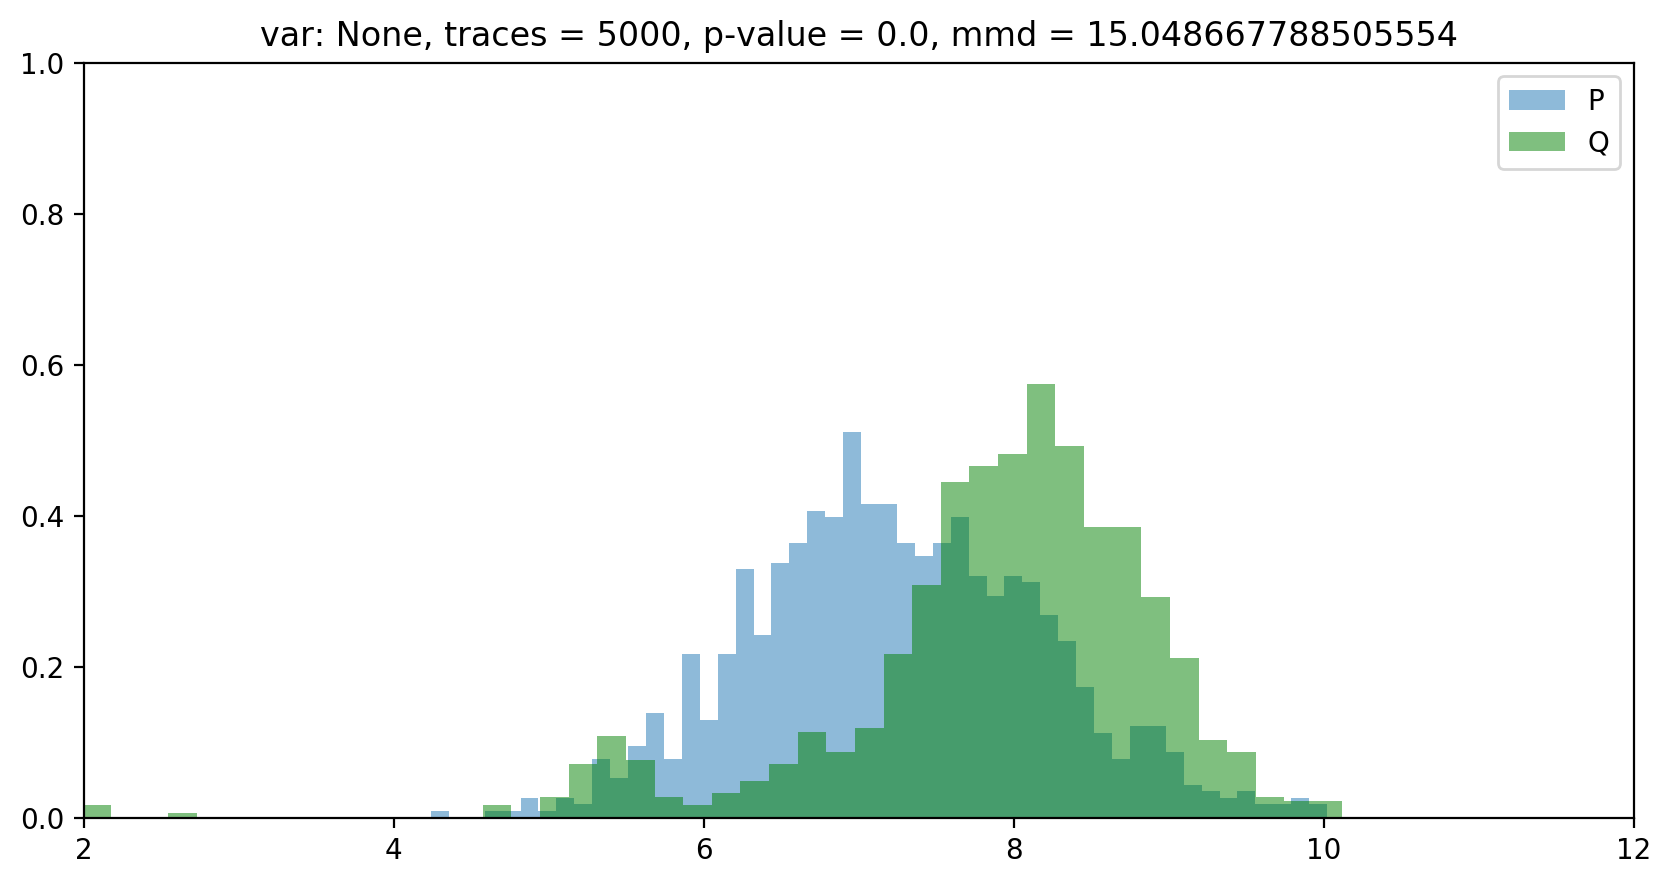

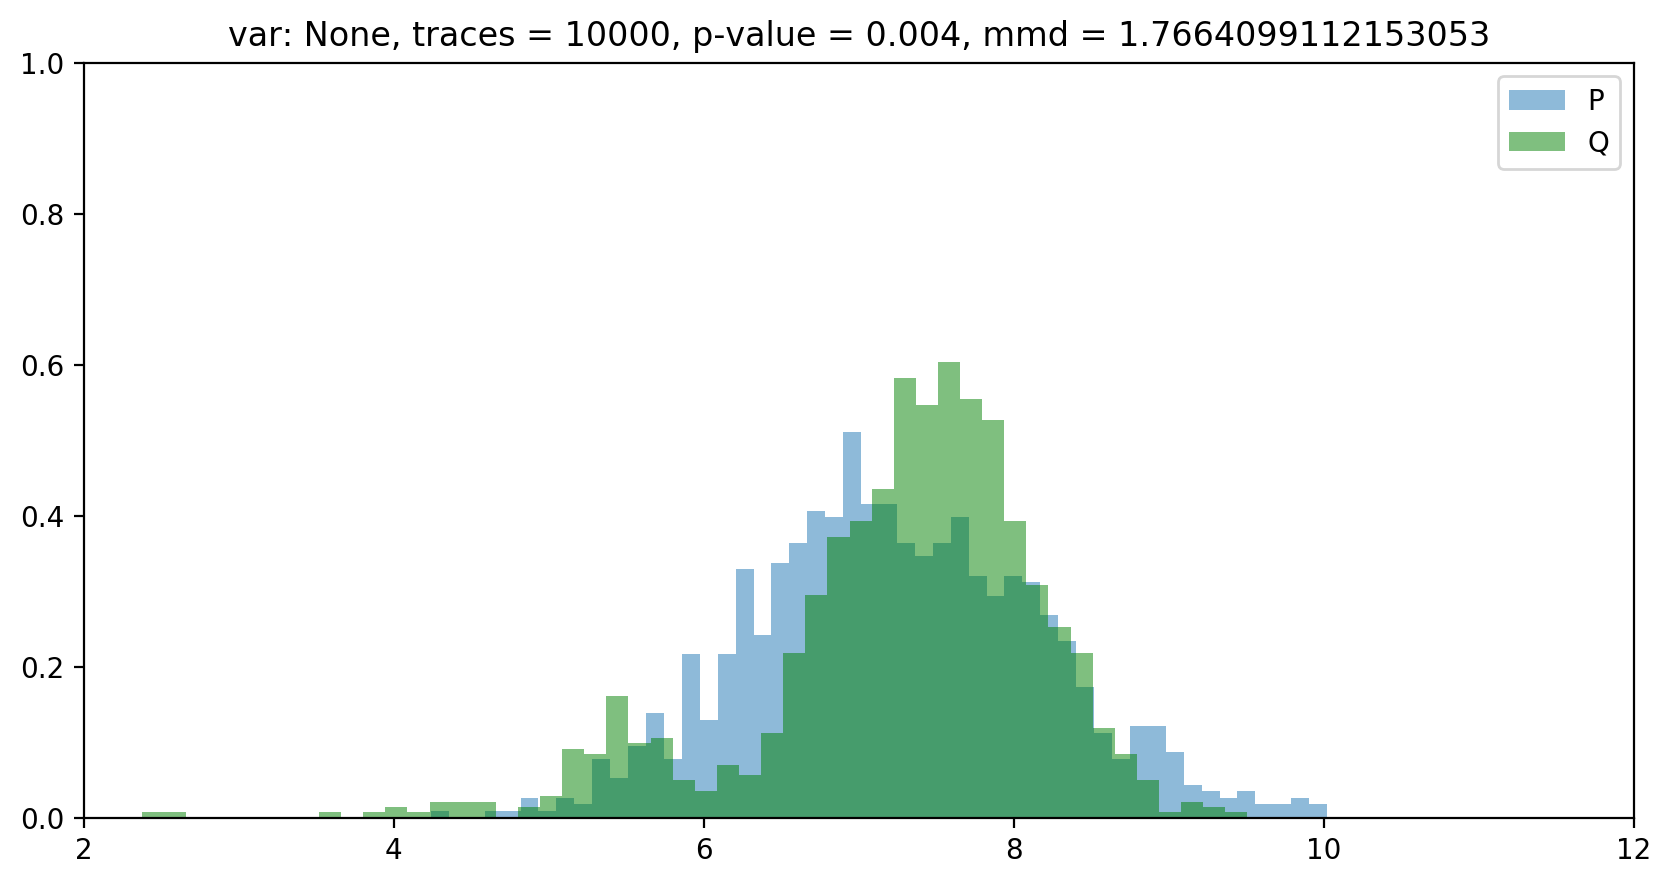

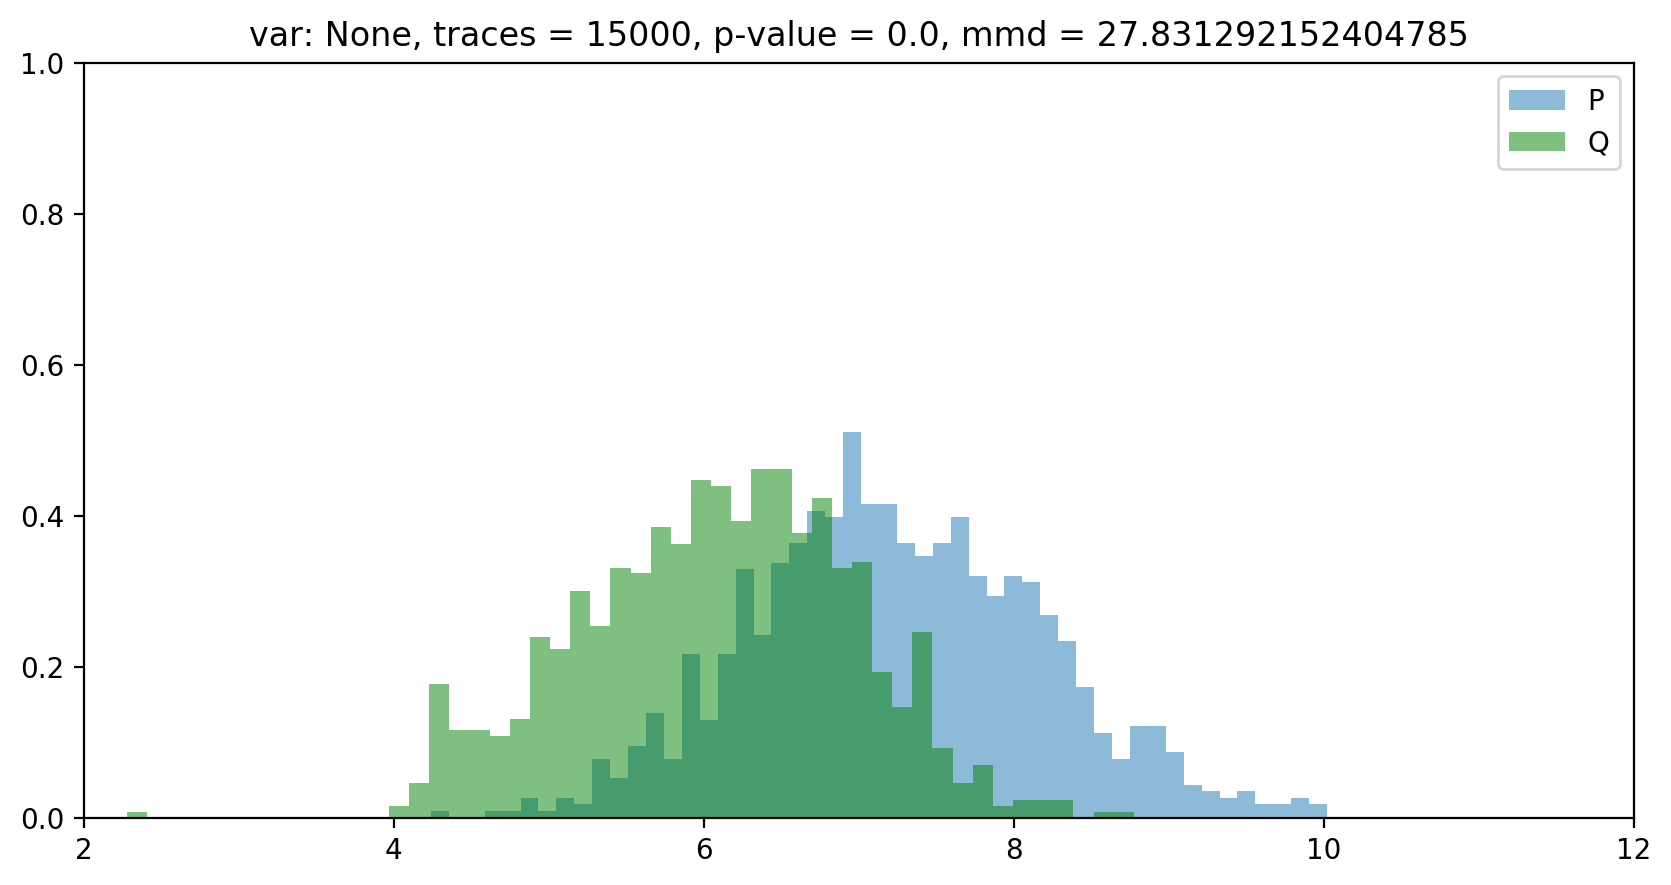

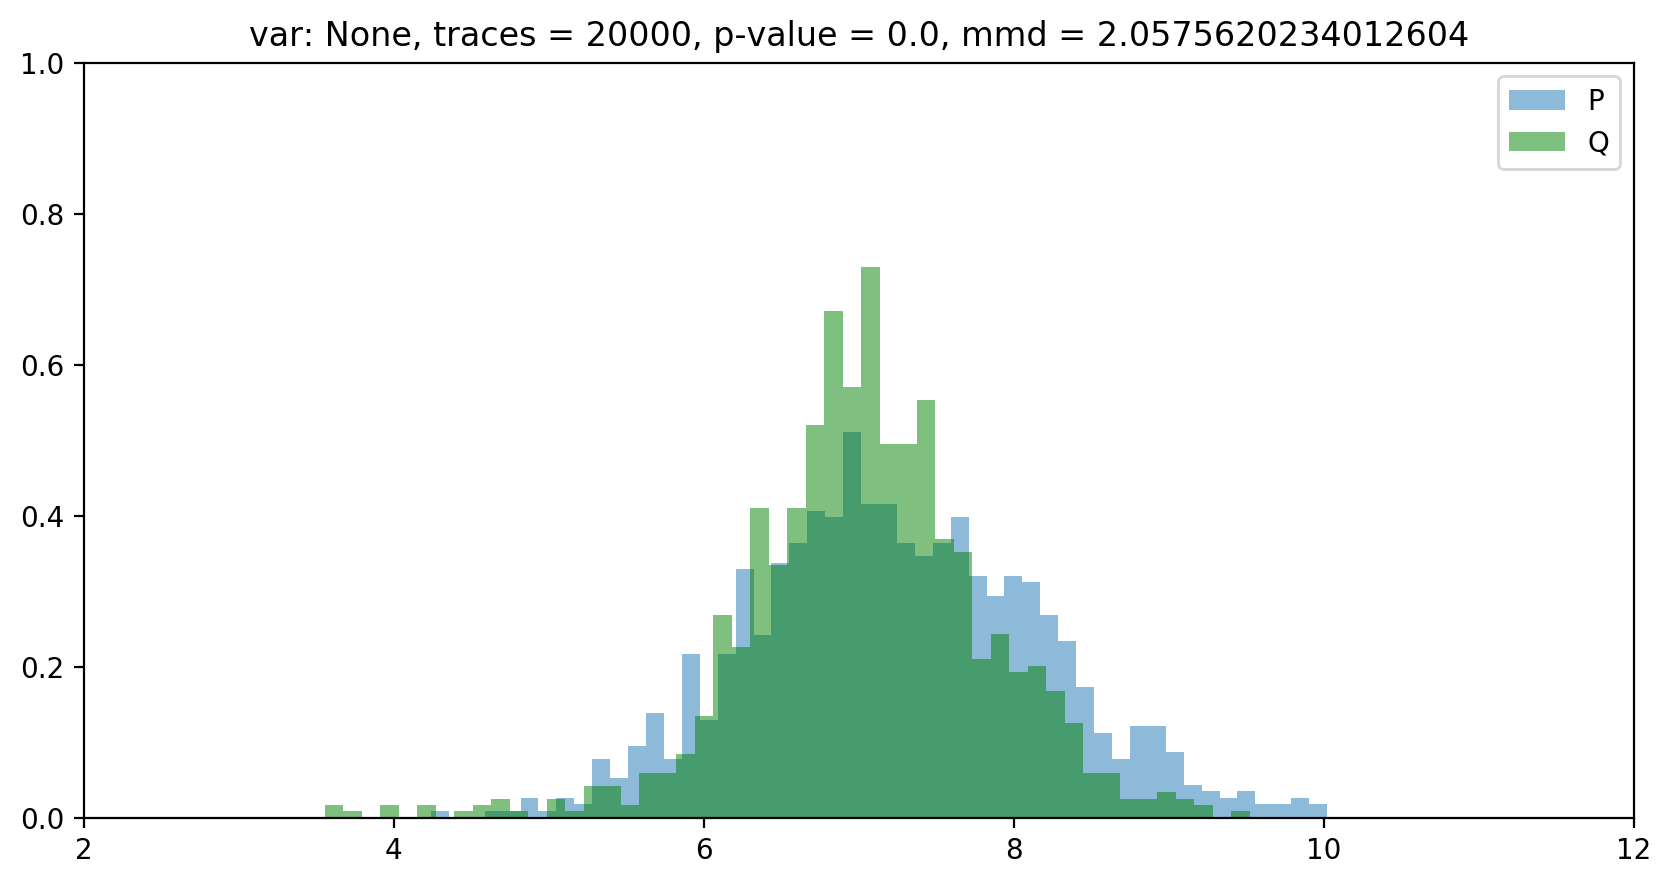

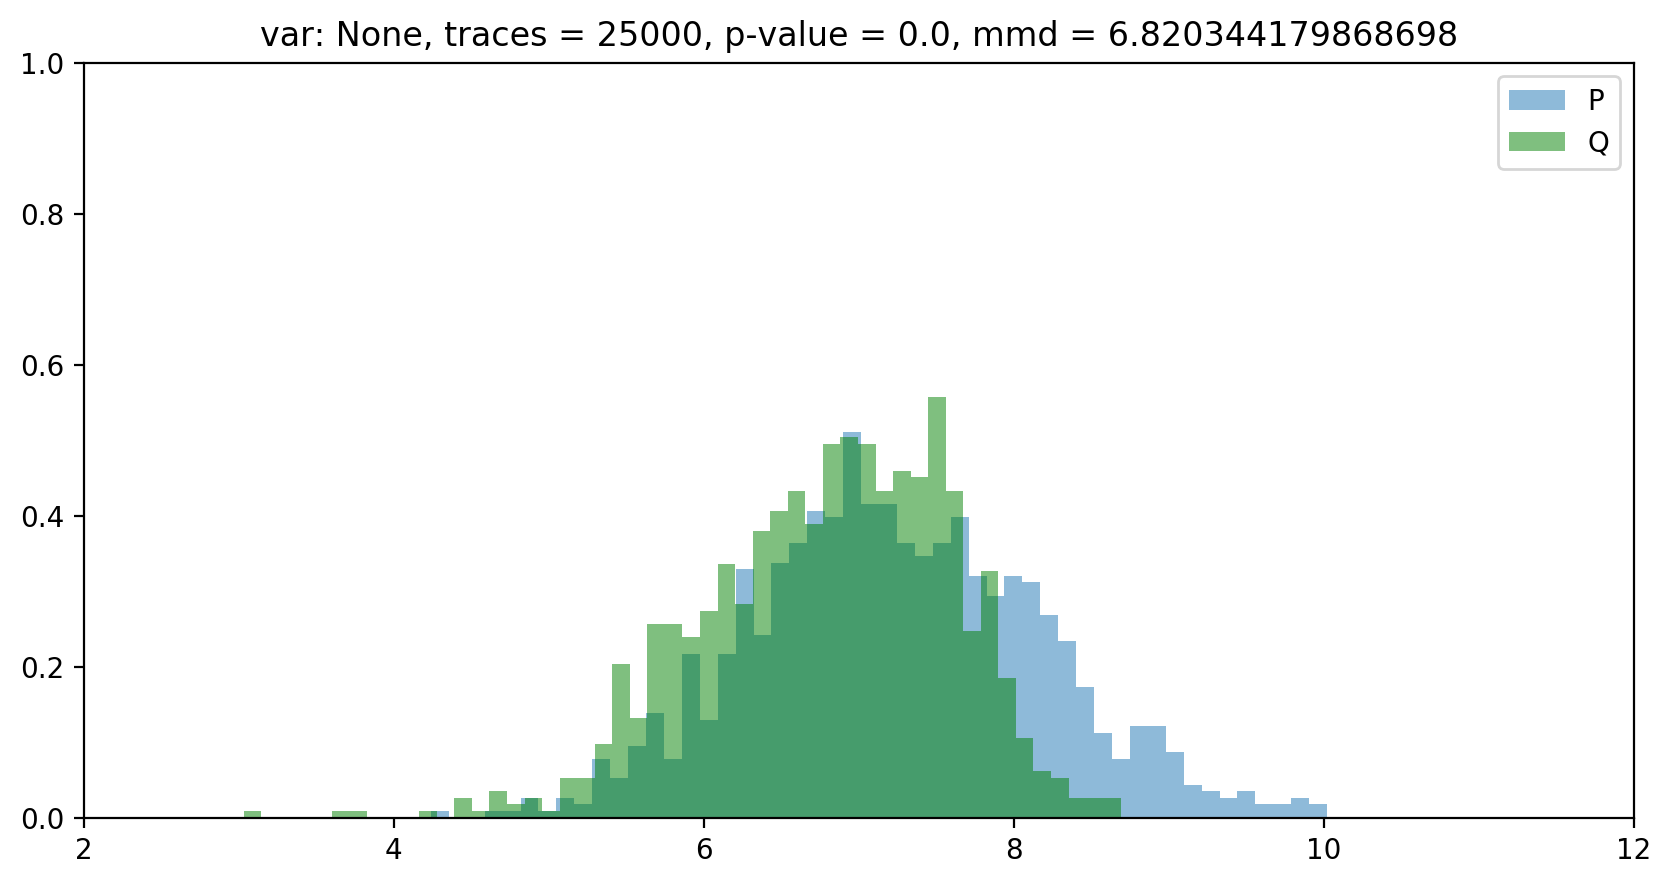

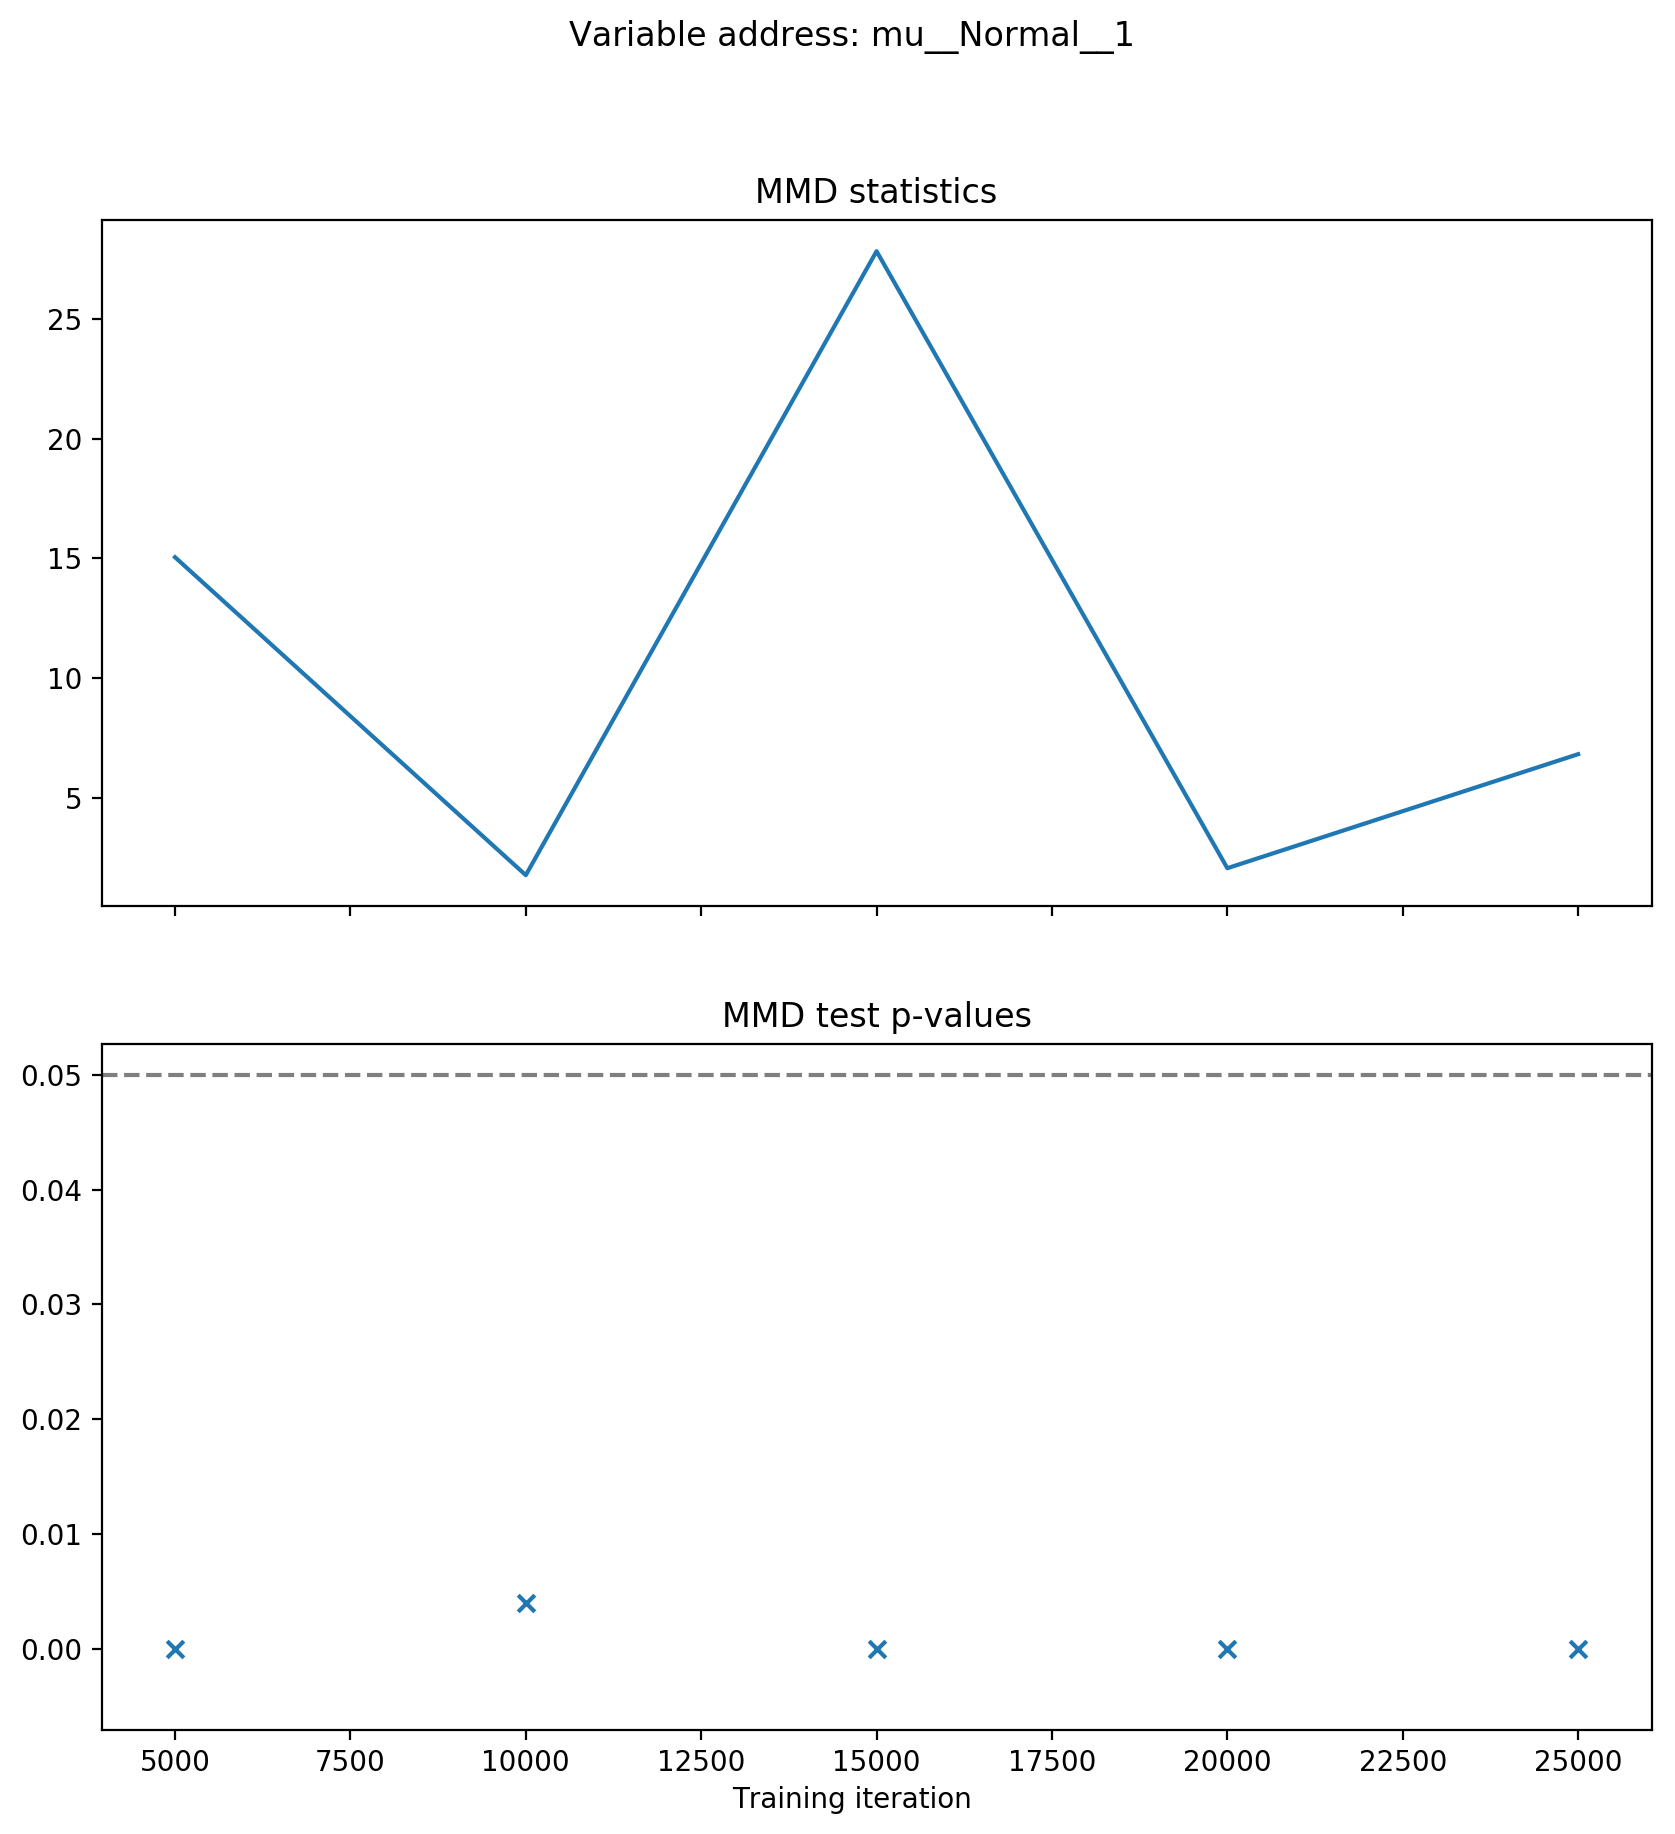

In [8]:
train_num_traces = 5000
logger = MMDLogger(store_plots)

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
for iter_num in range(5):
    model.learn_inference_network(num_traces=train_num_traces,
                              observe_embeddings={'obs0' : {'dim' : 64},
                                                  'obs1': {'dim' : 64}},
                              inference_network=pyprob.InferenceNetwork.FEEDFORWARD)
    # Draw traces from Q, i.e S_2
    trace_dist_q = model.posterior_traces(observe={'obs0': 8,
                                               'obs1': 9},
                                      num_traces=1000,
                                      inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK)
    # Perform MMD
    variable_values = diagnostics.mmd(trace_dist_p, trace_dist_q, mmd_num_epochs=50)
    
    # Print the statistics
    for v in variable_values.values():
            name = v['variable'].name
            address = v['variable'].address
            mmd = v['mmd']
            p_val = v['p_val']
            print('address: ', address)
            print('\tname: ', name)
            print('\tmmd: ', mmd)
            print('\tp-value: ', p_val)
    
    # Plot the stastistics
    logger.update(variable_values, (iter_num+1) * train_num_traces)
    
    logger.plotSummary() # Only plots if storing the plots

logger.close() # Plots the summary, no matter if storing the results or not.